In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Бинарная классификация

Задача бинарной классификации - найти правильное разбиение двух классов объктов в пространстве признаков. Рассмотрим простой пример такой классификации.

In [2]:
np.random.seed(42)

## 1.1 Простой пример с линейно разделимыми данными

In [3]:
X_1 = np.random.normal(size=(100,2)) 
y_1 = np.ones(100)
X_2 = np.random.normal(loc=5.0, size=(100,2))
y_2 = np.zeros(100)

X = np.concatenate((X_1, X_2), axis=0) # Полезная функция, которая позволяет состыковать два массива вдоль выбранной оси
y = np.concatenate((y_1, y_2), axis=0)

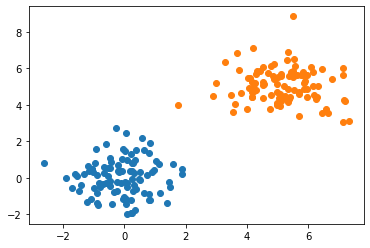

In [4]:
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.show()

Попробуем воспользоваться знанием о методе опорных векторов и построем гиперплоскость (т.е. линию в 2D), которая разделит нашу выборку в пространтсве признаков

In [5]:
from sklearn.svm import SVC # Импортируем классификатор из модуля svm библиотеки sklearn

In [6]:
model = SVC(kernel='linear') # Пока что выбираем линейное ядро, раз наши признаки линейно разделимы
model.fit(X,y)

SVC(kernel='linear')

Добавим еще несколько точек и посмотрим, как отработает алгортим на них

In [7]:
X_new = np.random.normal(loc=2.0, scale=1.0, size=(5,2))
y_new = model.predict(X_new)

In [8]:
X_new

array([[2.21868309, 1.51562431],
       [3.63885999, 2.22523535],
       [2.16642954, 2.80755563],
       [2.92415238, 2.81285646],
       [0.64927805, 1.36276447]])

In [9]:
y_new

array([1., 0., 0., 0., 1.])

Линейный классификатор использует функцию классификации вида $y = F(x) = sign((w,x) + b)$, где $w$ - вектор нормали к гиперплоскоти, а $b$ - свободный коэффициент. Зная их, можно построить саму гиперплоскость.

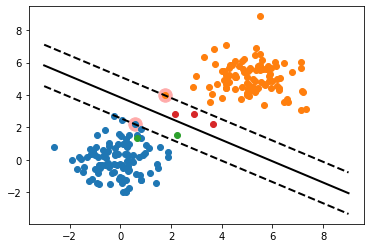

In [11]:
w = model.coef_[0]
b = model.intercept_[0]

x0 = np.linspace(-3.0, 9.0, 1000)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1] # Расстояние до опорных векторов
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model.support_vectors_ # Заодно отобразим, какое точки были выбраны в качестве опорных векторов
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFABAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.scatter(X_new[:,0][y_new==1], X_new[:,1][y_new==1])
plt.scatter(X_new[:,0][y_new==0], X_new[:,1][y_new==0])
plt.show()

Видно что данные хорошо разделимы и новые точки классифицированы правильно.

## 2.2 А что если они пересекаются?

Посмотрим как отработает алгоритм в этом случае. Создадим второе облачко поближе к первому, указав для него центр нормального распределения в точке (2.0, 2.0)

In [12]:
np.random.seed(12)
X_1 = np.random.normal(size=(100,2)) 
y_1 = np.ones(100)
X_2 = np.random.normal(loc=2.0, size=(100,2)) 
y_2 = np.zeros(100)

X = np.concatenate((X_1, X_2))
y = np.concatenate((y_1, y_2))

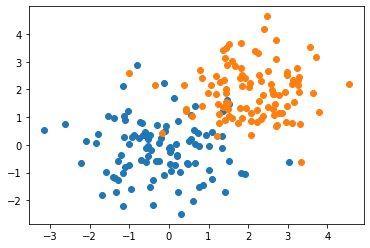

In [13]:
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Облака явно пересекаются, посмотрим как отработает линейный классификатор...

In [14]:
model = SVC(C=1000, kernel='linear')
model.fit(X,y)

SVC(C=1000, kernel='linear')

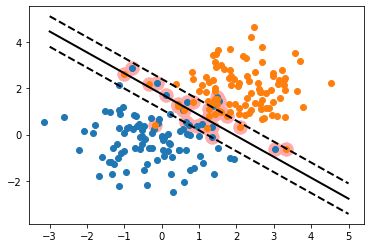

In [15]:
w = model.coef_[0]
b = model.intercept_[0]

x0 = np.linspace(-3.0, 5.0, 1000)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model.support_vectors_
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFABAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Он сделал все, что мог... Отметим, что опорных векторов может быть много, а не только два, как это было в предыдущем примере. Алгоритм сам находит, какие из точек ему удобно использовать. 

## 2.3 Нелинейная классификация

Классифицирующая фунцкция имеет вид $F(x) = sign((w, \phi(x)) + b)$. Строго говоря, классификация все еще линейная, но в пространстве большей размерности, т.е. все элементы выборки вкладываются в некоторое пространство $X$ по закону $\phi: \mathbb{R}^n \rightarrow X$, в котором они линейно разделимы.

Выражение $k(x,x') = (\phi(x), \phi(x'))$ называется ядром классификатора. Обычно используют следующие ядра:
* Полиномиальное : $(\gamma (x,x') + b)^d$
* Радиальная базисная функция (RBF) : $exp(-\gamma ||x - x'||^2)$
* Сигмоид : $tanh((x,x') + c)$

Обучим модель с гауссовым ядром и посморим, как она справится с задачей

In [16]:
model = SVC(kernel='rbf')
model.fit(X,y)

SVC()

Создадим сетку в пространстве признаков и вычилим значение классификатора в каждой точке

In [17]:
x0s = np.linspace(-4.0, 5.0, 100) 
x1s = np.linspace(-4.0, 5.0, 100)
x0, x1 = np.meshgrid(x0s, x1s) # Создает из двух одномерных массивов размера N1 и N2 двумерный массив N1xN2 - нашу сетку
XY = np.c_[x0.ravel(), x1.ravel()] # Немного переформатируем данные для подачи на вход классификатору
y_pred = model.predict(XY).reshape(x0.shape) # Это значния классификатора в каждой точке
y_decision = model.decision_function(XY).reshape(x0.shape) # Это его степень "уверенности" в своем решении

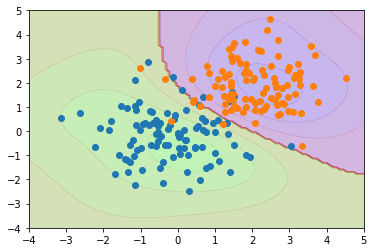

In [18]:
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2) # Нарисуем контурную карту значений...
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1) # ...а также линий уровня "уверенности"
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Видно, что алгоритм с гауссовым ядром справляется чуть лучше. Посмотрим на то, как подбор параметров может помочь в улучшении его работы.

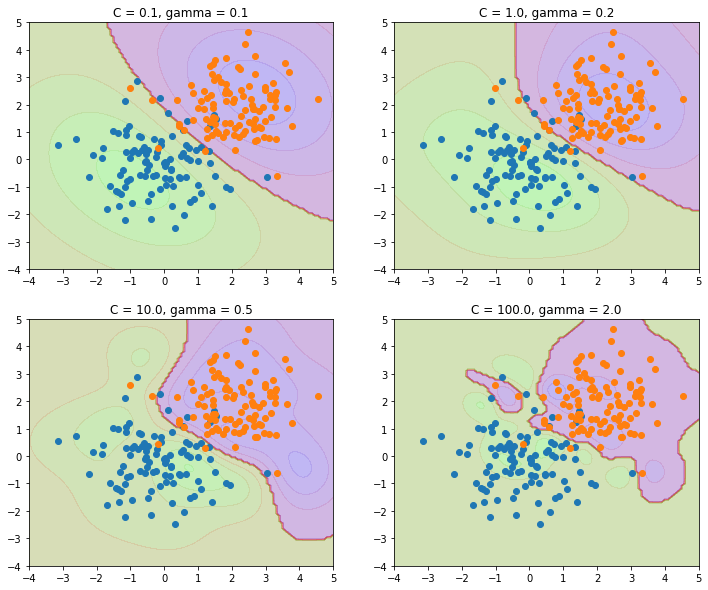

In [19]:
Cs = [0.1, 1.0, 10.0, 100.0]
gammas = [0.1, 0.2, 0.5, 2.0]
i = 0
plt.figure(figsize=(12, 10))
for i, coefs in enumerate(np.array([Cs, gammas]).T):
    C = coefs[0]
    gamma = coefs[1]
    model = SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X,y)
    
    x0s = np.linspace(-4.0, 5.0, 100)
    x1s = np.linspace(-4.0, 5.0, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    XY = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model.predict(XY).reshape(x0.shape)
    y_decision = model.decision_function(XY).reshape(x0.shape)
    
    plt.subplot(221 + i)
    plt.title('C = {}, gamma = {}'.format(C, gamma))
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    plt.scatter(X[:,0][y==1], X[:,1][y==1])
    plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()
    

На самом деле этот пример специфичен тем, что пересечение облаков на нем скорее похоже на старый-добрый шум в данных. Поэтому хоть модель стала сложнее, она не справляется сильно лучше, здесь достаточно было бы и линейного классификатора. Но есть и более интересные датасеты...

## 1.3. Задание: Датасет Steels

Итак, твое задание состоит в следующем:
1. Построй регрессор на основе метода опорных векторов. Для этого импортируй класс `sklearn.svm.SVR`
2. Обучи модель для предсказания `0.2% Proof Stress (MPa)` по составу стали и температуре, используя различные ядра: линейное, полиномиальное и гауссовское. Используй `StandardScaler` для скейлинга признаков. Влияет ли его наличие на качество модели? Попробуй объяснить результат. 
3. Найди для каждого из ядер наилучшие параметры: (`C, degree, coef0`) для полиномиального ядра, (`gamma, C`) для гауссовского.
4. Постарайся достигнуть наименьшей ошибки на тестовой выборке. Какая комбинация ядра и параметров дает наименьшую ошибку?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
df = pd.read_csv('Steels_kaggle.csv')
y = df[' 0.2% Proof Stress (MPa)']
X = df[[' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo', ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)']]
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=43)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
y_train, y_test = y_train.ravel(), y_test.ravel()

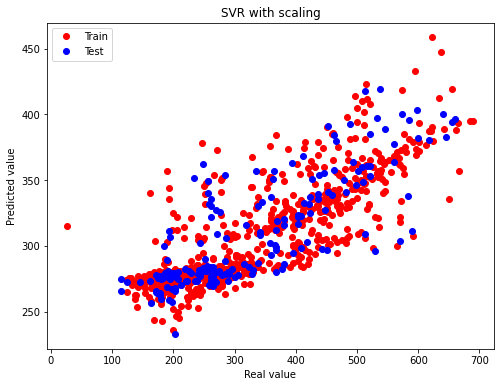

test: 104.0587798387592
train: 104.68865315975272


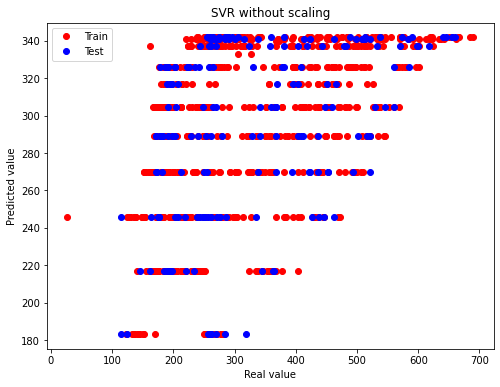

test: 127.11247015346939
train: 123.10346883351136


In [4]:
reg = SVR(kernel='poly')
reg.fit(X_train_scaled, y_train)
y_test_pred = reg.predict(X_test_scaled)
y_train_pred = reg.predict(X_train_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR with scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

reg = SVR(kernel='poly')
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR without scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

In [4]:
def gridresearch(params, scale=True):
    grid = ParameterGrid(params)
    kernel = params['kernel'][0]
    if scale == True:
        x_train = X_train_scaled.copy()
        x_test = X_test_scaled.copy()
        x = X_scaler.copy()
    else:
        x_train = X_train.copy()
        x_test = X_test.copy()
        x = X.copy()
    out = []
    num_folds = 5
    if kernel == 'linear':
        for params_ in tqdm(grid):
            reg = SVR(kernel='linear', C=params_['C'])
            reg.fit(x_train, y_train)
            y_test_pred = reg.predict(x_test)
            y_train_pred = reg.predict(x_train)

            score = cross_val_score(SVR(kernel='linear', C=params_['C']), x, y, cv=num_folds, scoring='neg_mean_squared_error')
            out.append([params_['C'], score.mean(), mse(y_test, y_test_pred, squared=False), mse(y_train, y_train_pred, squared=False)])
    elif kernel == 'poly':
        for params_ in tqdm(grid):
            print(params_)
            reg = SVR(kernel='poly', C=params_['C'], degree=params_['degree'], coef0=params_['coef0'])
            reg.fit(x_train, y_train)
            y_test_pred = reg.predict(x_test)
            y_train_pred = reg.predict(x_train)

            print('111')
            # score = cross_val_score(SVR(kernel='poly', C=params_['C'], degree=params_['degree'], coef0=params_['coef0']), x, y, cv=num_folds, scoring='neg_mean_squared_error')
            out.append([params_['C'], params_['degree'], params_['coef0'], mse(y_test, y_test_pred, squared=False), mse(y_train, y_train_pred, squared=False)])
    elif kernel == 'rbf':
        for params_ in tqdm(grid):
            print(params_)
            reg = SVR(kernel='rbf', C=params_['C'], gamma=params_['gamma'])
            reg.fit(x_train, y_train)
            y_test_pred = reg.predict(x_test)
            y_train_pred = reg.predict(x_train)

            score = cross_val_score(SVR(kernel='rbf', C=params_['C'], gamma=params_['gamma']), x, y, cv=num_folds, scoring='neg_mean_squared_error')
            out.append([params_['C'], params_['gamma'], score.mean(), mse(y_test, y_test_pred, squared=False), mse(y_train, y_train_pred, squared=False)])
    # print(out)
    np.savetxt(f'{kernel}_{scale}.txt', out)
    

In [5]:
# linear
params = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 10000],
    # 'C': [1],
    'kernel': ['linear']
}
# gridresearch(params)
gs_linear = GridSearchCV(SVR(), params, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)
gs_linear.fit(X_train_scaled, y_train)
print('лучшие параметры: ', gs_linear.best_params_)
print(f'cross validation("neg_MSE"): {gs_linear.best_score_}')

лучшие параметры:  {'C': 5, 'kernel': 'linear'}
cross validation("neg_MSE"): -2933.2286413994216


In [6]:
# rbf
params = {
    'C':  [0.1, 0.5, 1, 5, 10, 50, 100, 250, 500, 750, 1000],
    'gamma': np.arange(0.01, 1, 0.05),
    'kernel': ['rbf']
}
# gridresearch(params)
gs_rbf = GridSearchCV(SVR(), params, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
gs_rbf.fit(X_train_scaled, y_train)
gs_rbf.best_params_

{'C': 1000, 'gamma': 0.11, 'kernel': 'rbf'}

In [7]:
print('лучшие параметры: ', gs_rbf.best_params_)
print(f'cross validation("neg_MSE"): {gs_rbf.best_score_}')

лучшие параметры:  {'C': 1000, 'gamma': 0.11, 'kernel': 'rbf'}
cross validation("neg_MSE"): -989.4815764913865


In [5]:
# poly
params = {
    'C': [50, 100],
    'degree': [5],
    'coef0': [1, 5],
    'kernel': ['poly']
}
params = {
    'C': [10, 50, 100],
    'degree': [4, 5],
    'coef0': [1, 5, 10],
    'kernel': ['poly']
}
gridresearch(params)
# gs_poly = GridSearchCV(SVR(), params, n_jobs=-1, scoring='neg_mean_squared_error')
# gs_poly.fit(X_train_scaled, y_train)
# print('лучшие параметры: ', gs_poly.best_params_)
# print(f'cross validation("neg_MSE"): {gs_poly.best_score_}')

  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 50, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}


 25%|██▌       | 1/4 [00:00<00:02,  1.03it/s]

111
{'C': 50, 'coef0': 5, 'degree': 5, 'kernel': 'poly'}


 50%|█████     | 2/4 [01:42<01:02, 31.24s/it]

111
{'C': 100, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}


 75%|███████▌  | 3/4 [01:44<00:22, 22.31s/it]

111
{'C': 100, 'coef0': 5, 'degree': 5, 'kernel': 'poly'}


100%|██████████| 4/4 [04:45<00:00, 71.47s/it]

111


In [6]:
inp = ['rbf_True.txt', 'poly_True.txt']

for i, s in enumerate(inp):
    data = np.genfromtxt(s)
    # print(data[:, 2], np.argmin(data[:, 2]))
    print(s.split('_')[0])
    print('max crosvall(Neg_MSE)')
    print(list(data[np.argmax(data[:, i+1])]))
    print('min test')
    print(list(data[np.argmin(data[:, i+2])]))
    print()

linear
max crosvall(Neg_MSE)
[10.0, -4531.381422005073, 54.89198395985328, 53.09911700019668]
min test
[5.0, -4635.25911949958, 54.85728776486705, 53.097503455371246]

rbf
max crosvall(Neg_MSE)
[10.0, 0.01, -4531.381422005073, 67.81580535425528, 64.35990617685493]
min test
[1000.0, 0.11, -4669.316547776161, 21.302219119429807, 24.41165469248577]

poly
max crosvall(Neg_MSE)
[50.0, 5.0, 5.0, 20.044022016695457, 23.588457645430438]
min test
[100.0, 5.0, 5.0, 19.78683983139756, 23.38602635745793]



GridResearch выдал следующие результаты:

лучшие параметры:  {'C': 5, 'kernel': 'linear'}
cross validation("neg_MSE"): -2933.2286413994216

лучшие параметры:  {'C': 1000, 'gamma': 0.11, 'kernel': 'rbf'}
cross validation("neg_MSE"): -989.4815764913865

Для Poly GridSearch работал очень долго(более 2ух часов), я не дождался результата. Для своего grid_research у меня получилось найти мин на тесте. RMSE = 19.7 при C=100, coef0=5, degree=5. При тестировке ядра я заметил что при увеличении степени многочлена лучше результат, поэтому искал при оптимальных значениях. При degree = 6 алгоритм очень долго работал

Как видно со сккейлингом результат получается лучше. Линейное ядро плохо предсказывает. RBF со скейлингом не сильно хуже, чем poly (RMSD = 21.3) 

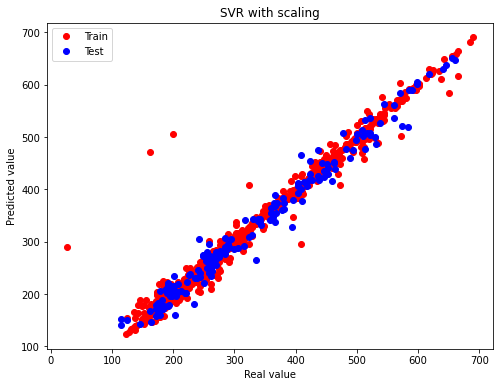

test: 19.78683983139756
train: 23.38602635745793


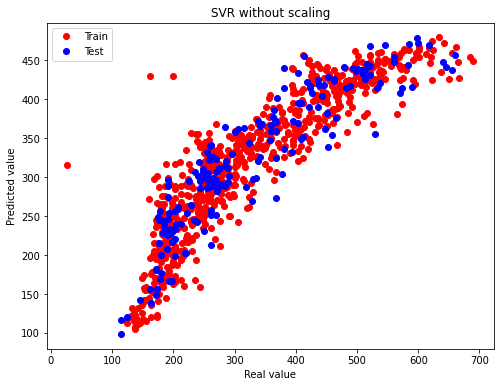

test: 65.85644516722161
train: 66.25313348085812


In [7]:
reg = SVR(kernel='poly', C=100, coef0=5, degree=5)
reg.fit(X_train_scaled, y_train)
y_test_pred = reg.predict(X_test_scaled)
y_train_pred = reg.predict(X_train_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR with scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

reg = SVR(kernel='poly', C=100, coef0=5, degree=5)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR without scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

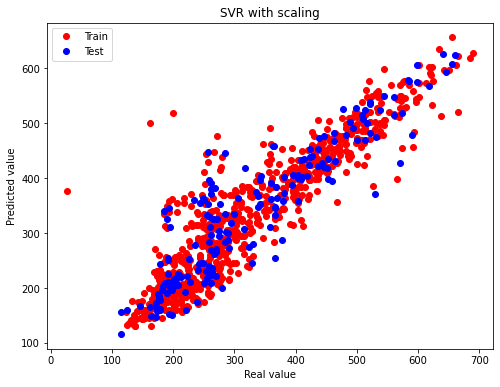

test: 54.85728776486705
train: 53.097503455371246


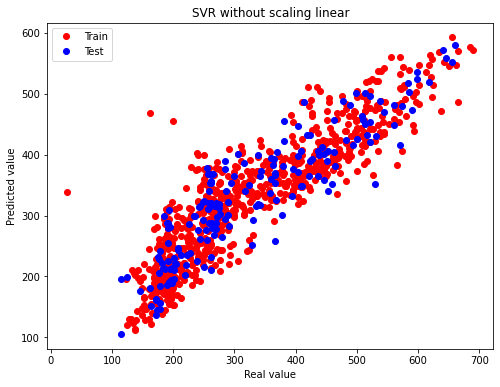

test: 59.76046175226932
train: 61.39807993253765


In [8]:
reg = SVR(kernel='linear', C=5)
reg.fit(X_train_scaled, y_train)
y_test_pred = reg.predict(X_test_scaled)
y_train_pred = reg.predict(X_train_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR with scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

reg = SVR(kernel='linear', C=5)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR without scaling linear')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

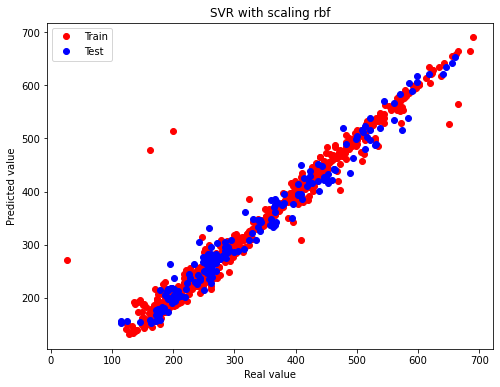

test: 21.302219119429807
train: 24.41165469248577


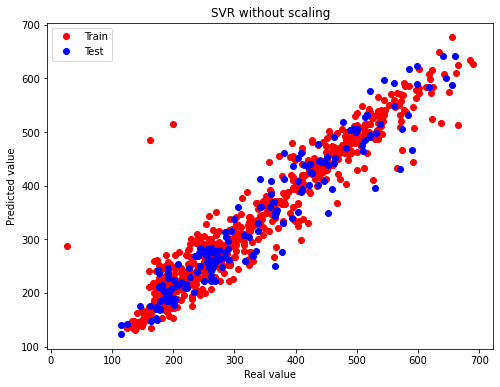

test: 36.16556505570158
train: 37.115020714892076


In [9]:
reg = SVR(**{'C': 1000, 'gamma': 0.11, 'kernel': 'rbf'})
reg.fit(X_train_scaled, y_train)
y_test_pred = reg.predict(X_test_scaled)
y_train_pred = reg.predict(X_train_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR with scaling rbf')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')

reg = SVR(**{'C': 1000, 'gamma': 0.11, 'kernel': 'rbf'})
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, 'or', label='Train')
plt.plot(y_test, y_test_pred, 'ob', label='Test')
plt.title('SVR without scaling')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()
print(f'test: {mse(y_test, y_test_pred, squared=False)}')
print(f'train: {mse(y_train, y_train_pred, squared=False)}')